# Data Ingestion

## Copy CSV files to S3

In [33]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

## Create Database, Tables and Parquets
### Database

In [29]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [30]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [31]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [32]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [ ]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


In [ ]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


In [ ]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


In [ ]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

In [ ]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


In [ ]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_body, user_location, candidatepoll

In [ ]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

In [ ]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


In [ ]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [ ]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

In [ ]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

In [ ]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

In [ ]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

In [ ]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

## Query Data

In [3]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [ ]:
#!pip install numpy==1.23.5
#!pip install matplotlib==3.4.3

In [ ]:
#import numpy
#import matplotlib

In [4]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [5]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

#"user_state", 


In [6]:
df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_trump.shape
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,#TRUMP #GENOCIDE💀💀 #COVID-19💀KIILLING HIS SUPP...,tweet,In Love with every breath...,Trump
1,#debatingEurope #EuropaImDiskurs @timothysnyd...,tweet,Vienna Austria,Trump
2,Raw as we like it 😅 #Trump is just awesome. Ye...,tweet,International,Trump
3,The law breaking is the strategy. #Trump https...,tweet,Evansville Indiana,Trump
4,"""69 000 new cases/day. Highest since July. Ove...",tweet,NYC,Trump


In [7]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)

# "user_state",
df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,#BidenHarris2020 #Biden #Trump 🥰 https://t.c...,tweet,London,Biden
1,@AgentGPF @charliekirk11 2% loss of #Biden wit...,tweet,the Netherlands,Biden
2,Ukraine congratulates #JoeBiden. https://t.co/...,tweet,Houston TX,Biden
3,@deptulahasrage Hey Walt where do we watch the...,tweet,SC,Biden
4,Y quienes lo celebran son los izquierdistas c...,tweet,Cerro Colorado Peru,Biden


# Data Exploration before Any Feature Transformation

In [ ]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

In [ ]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

In [ ]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


In [ ]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

In [ ]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

In [ ]:
df_parquet_results_biden['user_location'].value_counts()

In [ ]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

# Create EDA Overview Data Visualization

In [ ]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

## Standardizing Text Entries and Location Data

In [8]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 3.9 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
import re
import emoji

# Function to preprocess text data
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Replace emojis with text labels
    text = emoji.demojize(text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove "#" from hashtags
    text = re.sub(r'#', '', text)
    # Remove "@" from mentions
    text = re.sub(r'@', '', text)
    # Remove extra spaces while preserving at least one space between words
    text = re.sub(r'\s+', ' ', text)
    # Check if the text consists only of numbers
    if text.isdigit():
        text = "NA"
    return text



In [10]:
df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)
df_parquet_results_trump['user_location'] = df_parquet_results_trump['user_location'].astype(str)

/tmp/ipykernel_6272/682625606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['user_location'] = df_parquet_results_biden['user_location'].astype(str)


In [11]:
# Apply preprocessing to text columns in the dataframe
df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)

/tmp/ipykernel_6272/3431105715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_text'] = df_parquet_results_biden['comment_body'].apply(preprocess_text)


In [12]:
df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)

/tmp/ipykernel_6272/400958404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['clean_location'] = df_parquet_results_biden['user_location'].apply(preprocess_text)


In [13]:
df_parquet_results_trump['clean_text'] = df_parquet_results_trump['comment_body'].apply(preprocess_text)

In [14]:
df_parquet_results_trump['clean_location'] = df_parquet_results_trump['user_location'].apply(preprocess_text)

In [ ]:
df_parquet_results_trump.head()

In [ ]:
df_parquet_results_biden.head()

# Word Clouds with Comment Body Text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.1/520.1 kB 4.1 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


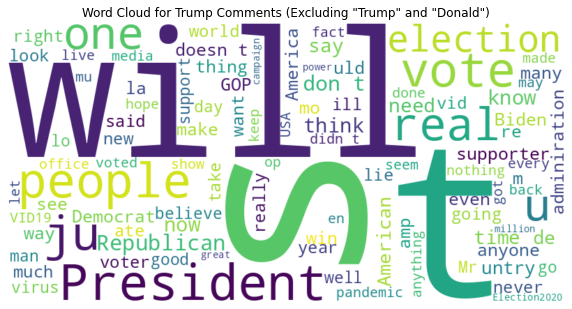

In [47]:
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['clean_text'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

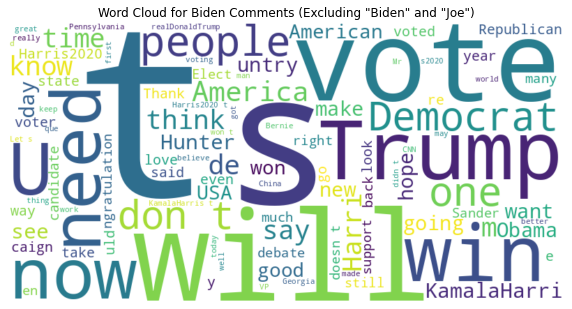

In [48]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['clean_text'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Feature Transformation and Data Cleaning

### Sentiment Labels Using Textblob and Stripping Out Non-English Text Entries with Fasttext.

### This code must be ran on Mac/Linux only. Windows is not compatible. Clean data from this code is stored in an S3 bucket and called below.

In [15]:
!pip install textblob
from textblob import TextBlob
def analyze_tweet_sentiment(tweet_text):
    analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    return analysis.sentiment.polarity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 5.6 MB/s eta 0:00:00:00:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [16]:
# Apply sentiment labels to Trump Data
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_trump = df_parquet_results_trump[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']

/tmp/ipykernel_6272/4017857091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_trump['sentiment_score'] = df_tweets_trump['clean_text'].apply(analyze_tweet_sentiment)


In [17]:
 # Apply Sentiment labels to Biden Data       
if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    df_tweets_biden = df_parquet_results_biden[['clean_text']]
    # Analyze sentiment for each tweet in the DataFrame
    df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


/tmp/ipykernel_6272/2765627512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_biden['sentiment_score'] = df_tweets_biden['clean_text'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_6272/2765627512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


In [ ]:
df_parquet_results_trump.head(5)

In [ ]:
df_parquet_results_biden.head(5)

## Combine candidate data

In [18]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

### Create sentiment labels

In [19]:
df_combined['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

In [ ]:

df_combined.head()


In [ ]:
df_combined.shape

# Additional EDA with Clean Language Data

## Trump Data

In [ ]:
# Examine Trump Sentiment distribution
df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'].value_counts()

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] < 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] == 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Trump') & (df_combined['sentiment'] > 0)].head(5)

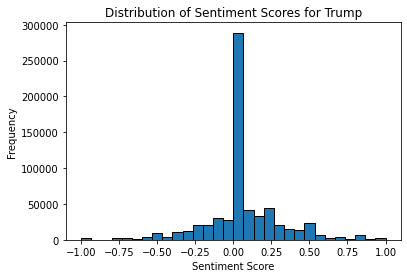

In [24]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Trump']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

### Biden Data

In [ ]:
df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'].value_counts()

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] < 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] == 0)].head(5)

In [ ]:
df_combined[(df_combined['candidatepoll'] == 'Biden') & (df_combined['sentiment'] > 0)].head(5)

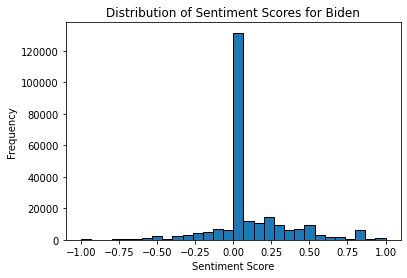

In [23]:
plt.hist(df_combined[df_combined['candidatepoll'] == 'Biden']['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Data Source Proportions with Clean Data

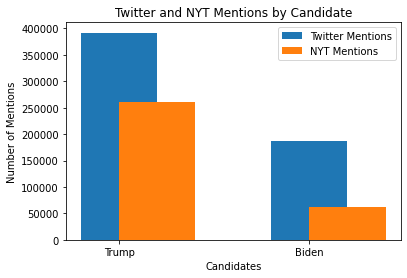

In [22]:
candidate = ['Trump','Biden']
twitter_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[0], 
             df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[0]]
nyt_n = [df_combined[df_combined['candidatepoll'] == 'Trump']['source'].value_counts()[1], 
         df_combined[df_combined['candidatepoll'] == 'Biden']['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

# Additional Feature Engineering

## Create Outcome Variable

In [20]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

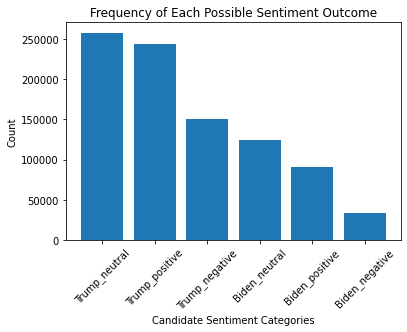

In [21]:
import matplotlib.pyplot as plt
category_counts = df_combined['SentimentOutcome'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Candidate Sentiment Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.ylabel('Count')
plt.title('Frequency of Each Possible Sentiment Outcome')
plt.show()

## Smallest category is Biden_negative. When using train/test/split with 90/5/5 ratio, we will need balancing.

In [ ]:
 df_combined[df_combined['candidatepoll'] == 'Biden']['SentimentOutcome'].value_counts()

In [ ]:
 df_combined[df_combined['candidatepoll'] == 'Trump']['SentimentOutcome'].value_counts()

In [ ]:
df_combined.head(5)


# Save Data to S3 bucket

In [25]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "cleandata.csv"

# Create an S3 client
s3 = boto3.client('s3')

#refine df_combined
df_combined_ref = df_combined[['source', 'clean_text', 'clean_location', 'candidatepoll', 'SentimentOutcome']]
df_combined_ref.head()

,source,clean_text,clean_location,candidatepoll,SentimentOutcome
0,tweet,BidenHarris2020 Biden Trump t co IqBz6MXYrY,London,Biden,Biden_neutral
1,tweet,AgentGPF charliekirk11 2 loss of Biden with a...,the Netherlands,Biden,Biden_negative
2,tweet,Ukraine congratulates JoeBiden t co 22HKsDw5Lt,Houston TX,Biden,Biden_neutral
3,tweet,deptulahasrage Hey Walt where do we watch the...,SC,Biden,Biden_negative
4,tweet,Y quienes lo celebran son los izquierdistas cu...,Cerro Colorado Peru,Biden,Biden_neutral


In [26]:
# Upload each file to S3
df_combined_ref.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

In [33]:
# Create temp table of df_combined
temp_table = "temp_table"
s3_private_path_cleandata = "s3://{}/ADS508_project/cleandata".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    source VARCHAR(20),
    clean_text VARCHAR(250),
    clean_location VARCHAR(25),
    candidatepoll VARCHAR(10),
    SentimentOutcome VARCHAR(10)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, temp_table, s3_private_path_cleandata
)

pd.read_sql(statement, conn)

""


In [34]:
# map df_combined/ cleandata with uscities by city
temp_table = "temp_table_city"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.city)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-04-12T20:16:14Z

end: 2024-04-12T20:16:20Z



In [35]:
# map df_combined/ cleandata with uscities by statename
temp_table = "temp_table_statename"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.state_name)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-04-12T20:16:20Z

end: 2024-04-12T20:16:44Z



In [36]:
# map df_combined/ cleandata with uscities by stateid
temp_table = "temp_table_stateid"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    t.source, 
    t.clean_text, 
    t.clean_location, 
    t.candidatepoll, 
    t.SentimentOutcome, 
    u.state_id
    FROM  dbpoliticpulsecomment.temp_table t
    LEFT JOIN dbpoliticpulsecomment.uscities u
        ON lower(t.clean_location) = lower(u.state_id)
    where state_id <> ''
)
""".format(database_name, temp_table)
pd.read_sql(statement, conn)

timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-04-12T20:16:49Z

end: 2024-04-12T20:17:01Z



In [37]:
# Create a combine of temp_table_state_id, _statename, _city
table_name = "cleandata"
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")

statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_stateid
UNION
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_city
UNION
SELECT DISTINCT 
    source, 
    clean_text, 
    clean_location, 
    candidatepoll, 
    SentimentOutcome, 
    state_id
    FROM  dbpoliticpulsecomment.temp_table_statename
)
""".format(database_name, table_name)
pd.read_sql(statement, conn)
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"end: {timestamp}\n")

start: 2024-04-12T20:17:05Z

end: 2024-04-12T20:17:13Z



In [38]:
# Drop all unused tables from Athena
drop_table_names = ["tweeter", "nyt_comment","uscities", "temp_table", "temp_table_statename", "temp_table_stateid", "temp_table_city"]

for table_name in drop_table_names:
    table_name = table_name

    statement = """
    DROP TABLE {}.{}
    """.format(database_name, table_name)
    
    pd.read_sql(statement, conn)

In [39]:
#==> SHOULD CREATE ANOTHER PARQUET OR READING FROM THIS? 
table_name = "cleandata"
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
df_combined_clean = pd.read_sql(statement, conn)
df_combined_clean.head(5)

,source,clean_text,clean_location,candidatepoll,sentimentoutcome,state_id
0,tweet,No one attacks David Attenborough yet for bein...,UK,Biden,Biden_nega,UK
1,tweet,The Adnams and the White Wine is tasting that ...,UK,Biden,Biden_posi,UK
2,tweet,philipaklein Biden VoteBidenHarris2020,NJ,Biden,Biden_neut,NJ
3,tweet,GOP realDonaldTrump without Biden we won t ha...,NY,Biden,Biden_neut,NY
4,nyt_comment,Washington Reader Many of us get your dissati...,CA,Biden,Biden_posi,CA


In [40]:
df_combined_clean.shape

(367831, 6)

# Examine State IDs by Outcome

In [41]:
df_final = df_combined_clean[['clean_text', 'state_id', 'sentimentoutcome']]

In [42]:
df_final['state_id'].value_counts()

NY    64743
CA    56088
TX    20717
FL    16768
MA    13979
NJ    13886
WA    13648
IL    13597
PA    13316
OH     9873
NC     8031
CO     7488
OR     6844
MI     6652
UK     6581
VA     6512
GA     6253
MD     6189
AZ     5945
CT     5900
WI     5525
MN     5422
MO     4039
WY     3250
NH     3219
NM     3017
IN     2945
IA     2852
LA     2688
ME     2501
NV     2494
SC     2442
TN     2258
VT     2213
ND     1992
RI     1864
AL     1719
KS     1497
AR     1445
OK     1443
KY     1432
ID     1102
UT     1041
MT     1003
HI      929
NE      838
AK      834
MS      824
DE      681
SD      555
WV      324
PR      290
BC      143
Name: state_id, dtype: int64

In [43]:
# Step 1: Filter the DataFrame for the top 10 states
top_5_states = df_final['state_id'].value_counts().head(5).index
filtered_df = df_final[df_final['state_id'].isin(top_5_states)]

# Step 2: Create a cross-tabulation (crosstab) with 'state_id' and 'sentimentoutcome'
cross_tab = pd.crosstab(filtered_df['state_id'], filtered_df['sentimentoutcome'])

# Display the cross-tabulation
print(cross_tab)

sentimentoutcome  Biden_nega  Biden_neut  Biden_posi  Trump_nega  Trump_neut  \
state_id                                                                       
CA                      1706        4008        4718       12139       14480   
FL                       505        1144        1426        3639        4217   
MA                       400         679        1048        3241        3498   
NY                      2047        3948        5536       13788       16541   
TX                       726        2755        1754        3558        6230   

sentimentoutcome  Trump_posi  
state_id                      
CA                     19037  
FL                      5837  
MA                      5113  
NY                     22883  
TX                      5694  


In [ ]:
df_final.head()

# Upload Final Data to S3

In [44]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "final_data.csv"

# Create an S3 client
s3 = boto3.client('s3')

df_final.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

# Load Final Data from S3 Bucket for Modeling

In [10]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/final_data.csv'

# Read CSV file from S3 bucket into DataFrame
df_final = pd.read_csv(f's3://{bucket_name}/{file_path}')

df_final.head()

,clean_text,state_id,sentimentoutcome
0,No one attacks David Attenborough yet for bein...,UK,Biden_nega
1,The Adnams and the White Wine is tasting that ...,UK,Biden_posi
2,philipaklein Biden VoteBidenHarris2020,NJ,Biden_neut
3,GOP realDonaldTrump without Biden we won t ha...,NY,Biden_neut
4,Washington Reader Many of us get your dissati...,CA,Biden_posi


In [11]:
df_final.shape

(367831, 3)

# Data Partition

### Assign input and outcome variables

In [12]:
X = df_final[['clean_text', 'state_id']]
y = df_final['sentimentoutcome']

### Create a 90/5/5 data split

In [13]:
from sklearn.model_selection import train_test_split

# Split data into 90% train and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Split remaining data (90% train) into 90% train and 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)

### Further undersample the training set so that each level of the outcome variable is equal

In [14]:
#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

# Undersample the training set to balance the six categorical outcome levels
undersampler = RandomUnderSampler(sampling_strategy='all', random_state=1)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

## Verify split datasets size and datatypes

In [15]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53382 entries, 13593 to 359016
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  53382 non-null  object
 1   state_id    53382 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [16]:
# Update Datatypes
X_train_resampled['clean_text'] = X_train_resampled['clean_text'].astype(str)
X_train_resampled['state_id'] = X_train_resampled['state_id'].astype('category')

In [17]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53382 entries, 13593 to 359016
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clean_text  53382 non-null  object  
 1   state_id    53382 non-null  category
dtypes: category(1), object(1)
memory usage: 888.7+ KB


In [18]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36784 entries, 252769 to 318746
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  36784 non-null  object
 1   state_id    36784 non-null  object
dtypes: object(2)
memory usage: 862.1+ KB


In [19]:
# Update Datatypes
X_test['clean_text'] = X_test['clean_text'].astype(str)
X_test['state_id'] = X_test['state_id'].astype('category')

In [20]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36783 entries, 139254 to 290197
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  36783 non-null  object
 1   state_id    36783 non-null  object
dtypes: object(2)
memory usage: 862.1+ KB


In [21]:
# Update Datatypes
X_val['clean_text'] = X_val['clean_text'].astype(str)
X_val['state_id'] = X_val['state_id'].astype('category')

In [22]:
X_train_resampled.shape, X_test.shape, X_val.shape

((53382, 2), (36784, 2), (36783, 2))

In [23]:
X_train_resampled.head()

,clean_text,state_id
13593,Andy Excuse me It is was the Dem leadership t...,CA
120356,Biden was a few one liners away from a decisive,TX
11253,MeOregon How dare you tell him that he would ...,CA
222260,Biden must use selected surrogates like Pete ...,MA
110164,Joe Biden s insane war on oil t co zoYQtDM0IS ...,NY


In [24]:
X_test.head()

,clean_text,state_id
252769,redwave trump Iowa Poll Trump takes lead from...,CA
5129,I hope Mr Krugman is right but let us not forg...,VA
311264,The Republican party had planted the seeds fo...,IL
144058,Note to anyone moving into rural areas functio...,VA
325429,ReaganBabe RudyGiuliani realDonaldTrump God i...,OH


In [25]:
X_val.head()

,clean_text,state_id
139254,It s one of the great ironies of the impeachm...,CA
25211,I think that some large number of people vote...,CA
16680,Hope Donald Trump reads this profile in wisdom...,MA
45661,Trump is good at Branding if nothing else He ...,NY
332714,Looking for some corroboration that Trump and...,WY


## Verify balance of training set

In [26]:
y_train_resampled.value_counts()

Biden_nega    8897
Biden_neut    8897
Trump_nega    8897
Trump_neut    8897
Trump_posi    8897
Biden_posi    8897
Name: sentimentoutcome, dtype: int64

## Average length of comments. 

In [22]:
# Function to count string word length
def count_word_length(text):
    words = text.split()
    return len(words)

# Add column to DataFrame
df_final['word_length'] = df_final['clean_text'].apply(lambda x: count_word_length(x))

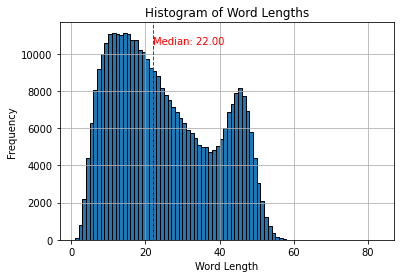

In [23]:
import matplotlib.pyplot as plt
import numpy as np
median_word_length = np.median(df_final['word_length'])

# Plot histogram of word lengths
plt.hist(df_final['word_length'], bins=range(min(df_final['word_length']), max(df_final['word_length']) + 1), edgecolor='black')
plt.axvline(median_word_length, color='red', linestyle='dashed', linewidth=1)  # Add vertical line at median
plt.text(median_word_length, plt.ylim()[1] * 0.9, f'Median: {median_word_length:.2f}', color='red')  # Add label for median
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.grid(True)
plt.show()

# Text Entry Preprocessing and Data Transformation Pipeline

In [ ]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
# pip install transformers

In [ ]:
#from transformers import DistilBertTokenizer, DistilBertModel
#import torch
#from sklearn.base import BaseEstimator, TransformerMixin
#from tqdm import tqdm
#import numpy as np

#class DistilBERTTransformer(BaseEstimator, TransformerMixin):
#    def __init__(self):
#        # Initialize the DistilBERT tokenizer and model
#        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
#        self.model.eval()  # Set model to evaluation mode
#    
#    def fit(self, X, y=None):
#        return self
#    
#    def transform(self, X, batch_size=32):
#        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#        self.model.to(device)
#        embeddings = []
#        for i in tqdm(range(0, len(X), batch_size)):
#            batch = X[i:i+batch_size]
#            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
#            with torch.no_grad():
#                outputs = self.model(**inputs)
#            embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy())  # Use mean pooling
#        return np.vstack(embeddings)

In [51]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import numpy as np

class DistilBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize the DistilBERT tokenizer and model
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.model.eval()  # Set model to evaluation mode
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, batch_size=32):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        embeddings = []
        for i in tqdm(range(0, len(X), batch_size)):
            batch = X[i:i+batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Adjust based on the actual structure of the outputs
            embeddings.append(outputs[0].mean(dim=1).detach().cpu().numpy())  # Use mean pooling
        return np.vstack(embeddings)

### BERT transformations

In [52]:
distilbert_transformer = DistilBERTTransformer()

In [26]:
# Transform 'clean_text' into DistilBERT embeddings for the training set
texts_train = X_train_resampled['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_train = distilbert_transformer.transform(texts_train)

100%|██████████| 1669/1669 [54:58<00:00,  1.98s/it] 


In [29]:
# Transform 'clean_text' into DistilBERT embeddings for the validation set
texts_val = X_val['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_val = distilbert_transformer.transform(texts_val)

100%|██████████| 1150/1150 [36:49<00:00,  1.92s/it]


In [53]:
# Transform 'clean_text' into DistilBERT embeddings for the test set
texts_test = X_test['clean_text'].tolist()  # Extract texts as a list
distilbert_embeddings_test = distilbert_transformer.transform(texts_test)


100%|██████████| 1150/1150 [36:47<00:00,  1.92s/it]


In [27]:
distilbert_embeddings_train = pd.DataFrame(distilbert_embeddings_train)

In [30]:
distilbert_embeddings_val = pd.DataFrame(distilbert_embeddings_val)

In [54]:
distilbert_embeddings_test = pd.DataFrame(distilbert_embeddings_test)

### Store Transformed BERT Dats

In [28]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "X_train_bert.csv"

# Create an S3 client
s3 = boto3.client('s3')

distilbert_embeddings_train.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

In [31]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "X_val_bert.csv"

# Create an S3 client
s3 = boto3.client('s3')

distilbert_embeddings_val.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

In [55]:
# Specify the S3 bucket name
prefix = "ADS508_project/cleandata/"

# List of corresponding file names
file_name = "X_test_bert.csv"

# Create an S3 client
s3 = boto3.client('s3')

distilbert_embeddings_test.to_csv(file_name, index=False)
s3.upload_file(file_name, bucket, prefix + file_name)

# Modeling

In [4]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Retrieve Data From S3

In [5]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_train_bert.csv'

# Read CSV file from S3 bucket into DataFrame
X_train_bert = pd.read_csv(f's3://{bucket_name}/{file_path}')

X_train_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.085612,-0.192749,0.032051,0.016743,-0.010959,-0.208290,-0.152666,0.297640,-0.075811,-0.289037,...,-0.051246,-0.057320,0.021458,-0.139488,0.223830,-0.117648,0.026695,0.062894,0.122807,0.167780
1,-0.212201,-0.275853,0.037405,0.060544,-0.318471,-0.185872,-0.159038,0.012011,0.002532,-0.199857,...,0.087239,0.060687,0.062437,-0.106997,0.098862,0.013423,-0.174617,0.141263,0.141340,-0.053384
2,0.086982,0.119298,0.000721,0.070849,0.078040,-0.039077,-0.055840,0.138417,-0.041773,-0.203287,...,0.111256,0.139934,0.032308,-0.068434,0.078629,0.111907,0.060399,-0.001812,0.050431,0.131460
3,-0.049801,-0.023380,0.220462,0.187448,0.186836,-0.236208,-0.012966,0.230729,0.106897,-0.068943,...,-0.259642,-0.024830,-0.060597,-0.137388,-0.050150,0.119264,0.116246,-0.047168,0.374222,-0.127046
4,0.043111,-0.095598,0.186926,0.210929,0.124437,-0.180557,0.122059,0.101528,-0.059285,-0.112962,...,-0.077179,0.120320,0.029574,-0.136716,0.225667,-0.055894,0.025724,-0.038090,0.036344,0.152835


In [6]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_val_bert.csv'

# Read CSV file from S3 bucket into DataFrame
X_val_bert = pd.read_csv(f's3://{bucket_name}/{file_path}')

X_val_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.020926,0.038315,-0.015478,0.129784,-0.072584,-0.225882,0.116951,0.300709,-0.293697,-0.131742,...,-0.101473,0.071148,-0.027571,-0.178902,0.104730,-0.137270,0.190230,0.047491,-0.023825,-0.075363
1,-0.119196,-0.174804,-0.049492,0.200089,0.020939,-0.033172,-0.113429,0.294107,-0.243626,0.038364,...,-0.145654,0.171014,0.051357,0.006363,0.185543,-0.155665,0.167436,-0.028334,0.032127,0.038196
2,0.023994,0.048203,0.132835,0.116420,0.221791,-0.144960,-0.026205,0.083955,0.105637,-0.224725,...,0.116835,0.203131,0.046252,-0.027101,0.172244,0.098827,0.036564,0.036217,0.111981,0.082348
3,0.075427,0.040858,0.099023,-0.004378,0.034570,-0.170367,0.052725,0.375484,0.045429,-0.236863,...,-0.018941,-0.022619,0.025490,-0.111980,0.260225,0.115471,0.041441,-0.069634,0.114876,-0.070295
4,0.127470,-0.034008,0.087723,0.135007,0.221004,-0.149747,0.064742,0.260640,0.016842,0.024366,...,-0.134856,0.003863,-0.123585,-0.110707,0.044464,0.125721,-0.036738,-0.023276,0.158410,0.098184


In [7]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_test_bert.csv'

# Read CSV file from S3 bucket into DataFrame
X_test_bert = pd.read_csv(f's3://{bucket_name}/{file_path}')

X_test_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.148748,-0.152604,0.410740,0.202116,0.018050,-0.217776,-0.022319,0.141656,0.011170,-0.119315,...,-0.049480,0.372685,-0.040204,-0.064451,0.203771,-0.123107,0.046268,0.038076,0.113842,0.215680
1,-0.028749,-0.105872,0.180524,0.218901,0.207626,-0.304348,-0.144124,0.339819,0.003144,-0.105429,...,0.006992,0.158822,-0.007336,-0.092584,0.222685,-0.048937,0.046246,-0.087520,0.137091,0.061183
2,-0.045923,-0.106403,-0.000612,0.198213,0.093984,-0.156729,-0.039995,0.291425,-0.124625,-0.062035,...,0.057361,0.214756,0.046441,-0.093943,0.152749,-0.130637,0.149418,-0.123415,0.063259,-0.038831
3,0.203205,-0.088243,0.242572,-0.091901,0.203277,-0.030754,0.085939,0.190463,-0.022583,-0.079250,...,-0.014764,0.016855,-0.007330,-0.096256,0.076464,-0.211883,0.041285,-0.305218,-0.115182,0.086422
4,-0.053510,0.018920,0.234078,0.105144,0.229481,-0.106339,-0.051445,0.502994,-0.241178,-0.332092,...,-0.159063,-0.021540,0.136380,-0.066743,0.057919,-0.100449,-0.008937,-0.049250,0.198628,0.050045


## Create Datasets with both BERT Text Data and One-Hot Encoded Location Data

In [27]:
X_train_resampled[['state_id']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53382 entries, 13593 to 359016
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   state_id  53382 non-null  category
dtypes: category(1)
memory usage: 471.6 KB


In [28]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse = False) 

# Assuming X_train, X_val, X_test are your datasets
state_ids_train = X_train_resampled[['state_id']] # Reshape for the encoder
state_id_encoded_train = onehot_encoder.fit_transform(state_ids_train)

# Get the feature names (levels of the categorical variable)
feature_names = onehot_encoder.get_feature_names_out(['state_id'])

# Convert the encoded matrix into a DataFrame
state_id_encoded_train_df = pd.DataFrame(state_id_encoded_train, columns=feature_names)

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
state_id_encoded_train_df.head()

,state_id_AK,state_id_AL,state_id_AR,state_id_AZ,state_id_BC,state_id_CA,state_id_CO,state_id_CT,state_id_DE,state_id_FL,...,state_id_TN,state_id_TX,state_id_UK,state_id_UT,state_id_VA,state_id_VT,state_id_WA,state_id_WI,state_id_WV,state_id_WY
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Assuming X_train, X_val, X_test are your datasets
state_ids_val = X_val[['state_id']] # Reshape for the encoder
state_id_encoded_val = onehot_encoder.fit_transform(state_ids_val)

# Get the feature names (levels of the categorical variable)
feature_names = onehot_encoder.get_feature_names_out(['state_id'])

# Convert the encoded matrix into a DataFrame
state_id_encoded_val_df = pd.DataFrame(state_id_encoded_val, columns=feature_names)

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
# Assuming X_train, X_val, X_test are your datasets
state_ids_test = X_test[['state_id']] # Reshape for the encoder
state_id_encoded_test = onehot_encoder.fit_transform(state_ids_test)

# Get the feature names (levels of the categorical variable)
feature_names = onehot_encoder.get_feature_names_out(['state_id'])

# Convert the encoded matrix into a DataFrame
state_id_encoded_test_df = pd.DataFrame(state_id_encoded_test, columns=feature_names)

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [40]:
import numpy as np
#Combine with sate ID that is one hot encoded
X_train_prep = pd.concat([X_train_bert, state_id_encoded_train_df], axis=1)

In [ ]:
X_val_prep = pd.concat([X_val_bert, state_id_encoded_val_df], axis=1)

In [38]:
X_test_prep = pd.concat([X_test_bert, state_id_encoded_test_df], axis=1)

In [41]:
X_train_prep.head()

,0,1,2,3,4,5,6,7,8,9,...,state_id_TN,state_id_TX,state_id_UK,state_id_UT,state_id_VA,state_id_VT,state_id_WA,state_id_WI,state_id_WV,state_id_WY
0,-0.085612,-0.192749,0.032051,0.016743,-0.010959,-0.208290,-0.152666,0.297640,-0.075811,-0.289037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.212201,-0.275853,0.037405,0.060544,-0.318471,-0.185872,-0.159038,0.012011,0.002532,-0.199857,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.086982,0.119298,0.000721,0.070849,0.078040,-0.039077,-0.055840,0.138417,-0.041773,-0.203287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.049801,-0.023380,0.220462,0.187448,0.186836,-0.236208,-0.012966,0.230729,0.106897,-0.068943,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043111,-0.095598,0.186926,0.210929,0.124437,-0.180557,0.122059,0.101528,-0.059285,-0.112962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_val_prep.head()

In [ ]:
X_test_prep.head()

In [ ]:
X_train_prep.info()

In [ ]:
X_val_prep.info()

In [ ]:
X_test_prep.info()

### Drop C-1 Dummies for Baseline Linear Models (i.e., logistic regression)

In [ ]:
X_train_log_reg = X_train_prep.iloc[:, :-1]

In [ ]:
X_val_log_reg = X_val_prep.iloc[:, :-1]

In [ ]:
X_test_log_reg = X_test_prep.iloc[:, :-1]

In [ ]:
X_train_log_reg.head()

In [ ]:
X_val_log_reg.head()

In [ ]:
X_test_log_reg.head()

In [ ]:
X_train_log_reg.info()

In [ ]:
X_val_log_reg.info()

In [ ]:
X_test_log_reg.info()

## Baseline: Logistic Regression with Text Data and Location (c-1 dummies)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Logistic Regression model
log_reg2 = LogisticRegression(max_iter=1000, solver='lbfgs')

# Fit the model on the balanced text training data
log_reg2.fit(X_train_log_reg, y_train_resampled)

# Predict on the validation set
y_val_pred = log_reg2.predict(X_val_log_reg)

# Evaluate the model
print("Baseline: Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nBaselin: Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))

In [ ]:
y_test_pred = log_reg2.predict(X_test_log_reg)
print("Baseline: Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nBaselin: Test Set Classification Report:\n", classification_report(y_test, y_test_pred))

# Ensemble Modeling

# AutoPilot Modeling

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.automl.automl import AutoML

role = get_execution_role()
session = sagemaker.Session()

# Replace 'your_dataset.csv' with the name of your CSV file
input_data = 's3://508group/ADS508_project/cleandata/df_final.csv'

autopilot_job = AutoML(
    role=role,
    target_attribute_name='sentimentoutcome',  # This is the column you're predicting
    output_path='s3://508group/ADS508_project/output/autopilot/',
    max_candidates=20,
    sagemaker_session=session,
    problem_type='MulticlassClassification',  # Assuming sentimentoutcome is multiclass
    job_objective={'MetricName': 'Accuracy'}  # You can choose another metric if it fits better
)

autopilot_job.fit(inputs=input_data, wait=False, logs=True)

In [ ]:
import boto3
import tarfile
import os

# Initialize the S3 client
s3 = boto3.client('s3')

# S3 bucket and object key
bucket_name = '508group'
object_key = 'ADS508_project/output/autopilot/automl-2024-03-30-19-51-00-981/data-processor-models/automl-2024-03-30-19-51-00-981-dpp9-1-89acfb1b856c4754873c58ddd/output/model.tar.gz'

# Local directory to extract the contents
extract_dir = "ADS508_project/output/autopilot/automl-2024-03-30-19-51-00-981/data-processor-models/automl-2024-03-30-19-51-00-981-dpp9-1-89acfb1b856c4754873c58ddd/output/model.tar.gz"

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the file from S3
local_file_path = os.path.join(extract_dir, 'model.tar.gz')
s3.download_file(bucket_name, object_key, local_file_path)

# Open the tar file and extract the contents
with tarfile.open(local_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

# After extraction, you can further process or use the contents of the extracted files
# For example, list the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)


In [ ]:
# Download the file from S3
local_file_path = os.path.join(extract_dir, 'model.tar.gz')
s3.download_file(bucket_name, object_key, local_file_path)

# Extract the contents of the tar.gz file
with tarfile.open(local_file_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)



In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.automl.automl import AutoML
import time
from datetime import datetime
from time import strftime
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")
role = get_execution_role()
session = sagemaker.Session()
# Replace 'your_dataset.csv' with the name of your CSV file
#input_data = 's3://508group/ADS508_project/cleandata/df_final.csv'
input_data = 's3://sagemaker-us-east-1-851725336500/ADS508_project/cleandata/final_data.csv'
autopilot_job = AutoML(
    role=role,
    target_attribute_name='sentimentoutcome',  # This is the column you're predicting
    #output_path='s3://508group/ADS508_project/output/autopilot/',
    output_path= 's3://sagemaker-us-east-1-851725336500/ADS508_project/output/autopilot/',
    max_candidates=20,
    sagemaker_session=session,
    problem_type='MulticlassClassification',  # Assuming sentimentoutcome is multiclass
    job_objective={'MetricName': 'Accuracy'}  # You can choose another metric if it fits better
)
autopilot_job.fit(inputs=input_data, wait=True, logs=True)
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
print(f"start: {timestamp}\n")


In [ ]:
# R-001
Name
automl-2024-04-01-18-34-15-211xR-001-416b37f8-aws-training-job
ARN
arn:aws:sagemaker:us-east-1:851725336500:experiment-trial-component/automl-2024-04-01-18-34-15-211xR-001-416b37f8-aws-training-job

#Image URI
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3

# Instance Info - 1 instance - 50GB
ml.m5.12xlarge

#Lambda
0.015482990568956176

#Max depth
6

#Min child weight
0.0016695027194522027

#Num class
6

#Num round
967

#Objective
multi:softprob

# Model artifact
s3://sagemaker-us-east-1-851725336500/ADS508_project/output/autopilot/automl-2024-04-01-18-34-15-211/tuning/automl-202-dpp7-xgb/automl-2024-04-01-18-34-15-211xR-001-416b37f8/output/model.tar.gz

In [ ]:
# XGBoost 1: Key Term "R-002"
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3
s3://sagemaker-us-east-1-851725336500/ADS508_project/output/autopilot/automl-2024-04-01-18-34-15-211/tuning/automl-202-dpp6-xgb/automl-2024-04-01-18-34-15-211xR-002-6a1fdd29/output/model.tar.gz

# XGBoost

In [ ]:
# Add outcome column to training set
import pandas as pd
import boto3
from io import StringIO

# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_train_bert.csv'

# Read CSV file from S3 bucket into DataFrame
s3 = boto3.client('s3')
response = s3.get_object(Bucket=bucket_name, Key=file_path)
X_train_bert = pd.read_csv(response['Body'])

# Add a new column to the DataFrame
X_train_bert['sentimentoutcome'] = pd.Categorical(y_train_resampled)

# Write the modified DataFrame to a CSV file
csv_buffer = StringIO()
X_train_bert.to_csv(csv_buffer, index=False)

# Upload the updated CSV file to the S3 bucket, replacing the original file
s3.put_object(Bucket=bucket_name, Key=file_path, Body=csv_buffer.getvalue())

In [ ]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_val_bert.csv'

# Read CSV file from S3 bucket into DataFrame
s3 = boto3.client('s3')
response = s3.get_object(Bucket=bucket_name, Key=file_path)
X_val_bert = pd.read_csv(response['Body'])

# Add a new column to the DataFrame
X_val_bert['sentimentoutcome'] = pd.Categorical(y_val)

# Write the modified DataFrame to a CSV file
csv_buffer = StringIO()
X_val_bert.to_csv(csv_buffer, index=False)

# Upload the updated CSV file to the S3 bucket, replacing the original file
s3.put_object(Bucket=bucket_name, Key=file_path, Body=csv_buffer.getvalue())

In [ ]:
# Specify the S3 bucket name and file path
bucket_name = bucket
file_path = 'ADS508_project/cleandata/X_test_bert.csv'

# Read CSV file from S3 bucket into DataFrame
s3 = boto3.client('s3')
response = s3.get_object(Bucket=bucket_name, Key=file_path)
X_test_bert = pd.read_csv(response['Body'])

# Add a new column to the DataFrame
X_test_bert['sentimentoutcome'] = pd.Categorical(y_test)

# Write the modified DataFrame to a CSV file
csv_buffer = StringIO()
X_test_bert.to_csv(csv_buffer, index=False)

# Upload the updated CSV file to the S3 bucket, replacing the original file
s3.put_object(Bucket=bucket_name, Key=file_path, Body=csv_buffer.getvalue())

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

# Define IAM role
role = get_execution_role()

# Define SageMaker session
sess = sagemaker.Session()

# Define S3 bucket and prefix
bucket = 'your-s3-bucket-name'
prefix = 'your-prefix'

# Specify the training data location in S3
train_input = TrainingInput(f's3://{bucket}/{prefix}/train.csv', content_type='text/csv')

# Get the XGBoost container image
container = get_image_uri(sess.boto_region_name, 'xgboost', repo_version='1.2-1')

# Define hyperparameters
hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "reg:linear",
    "num_round": "50"
}

# Create an estimator object
xgb_estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    hyperparameters=hyperparameters
)

# Set the output location for model artifacts
output_path = f's3://{bucket}/{prefix}/output'
xgb_estimator.output_path = output_path

# Train the model
xgb_estimator.fit({'train': train_input})


## MLP Model 1

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Use a pipeline to standardize features
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, activation='relu', solver='adam', verbose=True, tol=0.001, alpha=0.0001)
)

# Fit the model
mlp_pipeline.fit(X_train_prepared, y_train)

# Predict and evaluate
y_val_pred = mlp_pipeline.predict(X_val_prepared)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))


## MLP Model

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP Classifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', verbose=True, tol=0.01)


# Fit the model on the training data
mlp.fit(X_train_prepared, y_train)

# Predict on the validation set
y_val_pred_mlp = mlp.predict(X_val_prepared)

# Evaluate the model
print("Validation Set Accuracy (MLP):", accuracy_score(y_val, y_val_pred_mlp))
print("\nValidation Set Classification Report (MLP):\n", classification_report(y_val, y_val_pred_mlp))


## Transformer 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Define device upfront
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train_prepared, X_val_prepared, X_test_prepared and their respective y's are already defined

# Encode labels numerically
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.features[idx], dtype=torch.float),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Dataset and DataLoader
train_dataset = CustomDataset(X_train_prepared, y_train_encoded)
val_dataset = CustomDataset(X_val_prepared, y_val_encoded)
test_dataset = CustomDataset(X_test_prepared, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model Definition
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier(input_size=X_train_prepared.shape[1], num_classes=len(set(y_train_encoded)))
model.to(device)

# Training
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        features, labels = batch['features'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        features, labels = batch['features'].to(device), batch['labels'].to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))



In [ ]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Ensure your DataFrame variables are defined here (X_train, y_train_resampled, X_test, y_test, X_val, y_val)

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#         print(f"Successfully uploaded {key}")
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")

# # Define the S3 paths for the data now that they are uploaded
# s3_paths = {
#     'X_train': 's3://508group/ADS508_project/cleandata/X_train.csv',
#     'y_train_resampled': 's3://508group/ADS508_project/cleandata/y_train_resampled.csv',
#     'X_test': 's3://508group/ADS508_project/cleandata/X_test.csv',
#     'y_test':  's3://508group/ADS508_project/cleandata/y_test.csv',
#     'X_val': 's3://508group/ADS508_project/cleandata/X_val.csv',
#     'y_val': 's3://508group/ADS508_project/cleandata/y_val.csv',
# }
# output_path = 's3://508group/ADS508_project/output/'

# You can now use `s3_paths` dictionary to access your data in S3 for any further processing


In [ ]:
# !pip install -U sagemaker

In [ ]:
# pip install XGBoost

In [ ]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")


In [ ]:
# # Define the S3 paths for training data, model output, etc.
# X_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# y_train_resampled = 's3://508group/ADS508_project/cleandata/y_train_resampled.csv'
# X_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# y_test =  's3://508group/ADS508_project/cleandata/y_test.csv'
# X_val = 's3://508group/ADS508_project/cleandata/X_val.csv'
# y_val = 's3://508group/ADS508_project/cleandata/y_val.csv'
# output_path = 's3://508group/ADS508_project/output/'


In [ ]:
# import sagemaker
# from sagemaker import get_execution_role
# from sagemaker.inputs import TrainingInput
# from sagemaker.estimator import Estimator

# # Step 1: Define S3 paths for training data, model output, etc.
# s3_input_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# s3_input_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# output_path = 's3://508group/ADS508_project/output/'

# # Step 2: Create a SageMaker session and specify the IAM role
# sagemaker_session = sagemaker.Session()
# role = get_execution_role()

# # Step 3: Define the SageMaker XGBoost estimator with the specific version and hyperparameters
# xgb_estimator = Estimator(image_uri=sagemaker.image_uris.retrieve("xgboost", sagemaker_session.boto_region_name, "1.7-1"),
#                           role=role,
#                           instance_count=1,
#                           instance_type='ml.m5.large',
#                           output_path=output_path,
#                           sagemaker_session=sagemaker_session,
#                           hyperparameters={'num_round': '10'})  # Specify the number of boosting rounds

# # Step 4: Train the XGBoost model
# xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

In [ ]:
# import boto3
# import os

# # Initialize a boto3 client
# s3 = boto3.client('s3')

# # Function to download a file from an S3 bucket
# def download_file(bucket_name, object_key, local_filename):
#     try:
#         s3.download_file(Bucket=bucket_name, Key=object_key, Filename=local_filename)
#         print(f"Downloaded {object_key} to {local_filename}")
#     except Exception as e:
#         print(f"Error downloading {object_key}: {e}")

# # Define your bucket name
# bucket_name = '508group'

# # List of artifacts to download
# artifacts = {
#     "feature_engineering_code": "ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp9.py",
#     # Add other artifacts here following the same structure
# }

# # Download each artifact
# for name, key in artifacts.items():
#     download_file(bucket_name, key, f"{name}.py")


In [ ]:
# import boto3
# import os

# # Define key for the feature engineering code
# fe_code_key = 'ADS508_project/output/autopilot/automl-2024-03-30-19-48-01-733/sagemaker-automl-candidates/automl-2024-03-30-19-48-01-733-pr-1-5cdcc23566e2483f97658942125/generated_module/candidate_data_processors/dpp3.py'
# download_from_s3(bucket_name, fe_code_key, 'dpp3.py')

In [ ]:
# import boto3
# import os

# s3 = boto3.client('s3')

# def download_from_s3(bucket_name, s3_key, local_path):
#     try:
#         s3.download_file(bucket_name, s3_key, local_path)
#         print(f"Downloaded {s3_key} to {local_path}")
#     except Exception as e:
#         print(f"Error downloading {s3_key}: {e}")

# bucket_name = '508group' 

In [ ]:
# import boto3
# import pandas as pd
# from io import StringIO

# # Create an S3 client
# s3 = boto3.client('s3')

# # Specify the name of the bucket
# bucket_name = '508group'

# # Define the DataFrames
# data_frames = {
#     'X_train': X_train,
#     'y_train_resampled': y_train_resampled,
#     'X_test': X_test,
#     'y_test': y_test,
#     'X_val': X_val,
#     'y_val': y_val,
# }

# # Upload each DataFrame as CSV to the "508group" bucket
# for key, df in data_frames.items():
#     try:
#         # Convert DataFrame to CSV string
#         csv_buffer = StringIO()
#         df.to_csv(csv_buffer, index=False)
        
#         # Upload CSV string to S3
#         s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=f'ADS508_project/cleandata/{key}.csv')
#     except Exception as e:
#         print(f"Error uploading {key} to S3: {e}")



In [ ]:
# import sagemaker
# from sagemaker.tensorflow import TensorFlow

# # Define your SageMaker session
# sagemaker_session = sagemaker.Session()

In [ ]:
# # Define the S3 paths for training data, model output, etc.
# X_train = 's3://508group/ADS508_project/cleandata/X_train.csv'
# y_train_resampled = 's3://508group/ADS508_project/cleandata/y_train_resampled.csv'
# X_test = 's3://508group/ADS508_project/cleandata/X_test.csv'
# y_test =  's3://508group/ADS508_project/cleandata/y_test.csv'
# X_val = 's3://508group/ADS508_project/cleandata/X_val.csv'
# y_val = 's3://508group/ADS508_project/cleandata/y_val.csv'
# output_path = 's3://508group/ADS508_project/output/'


In [ ]:

# # Load y_train_resampled.csv
# y_train_resampled_df = pd.read_csv('s3://508group/ADS508_project/cleandata/y_train_resampled.csv')

# # Prefix labels with '__label__'
# y_train_resampled_df['sentimentoutcome'] = '__label__' + y_train_resampled_df['sentimentoutcome'].astype(str)

# # Save the modified DataFrame back to y_train_resampled.csv
# y_train_resampled_df.to_csv('s3://508group/ADS508_project/cleandata/y_train_resampled.csv', index=False)


# # Load y_val.csv
# y_val_df = pd.read_csv('s3://508group/ADS508_project/cleandata/y_val.csv')

# # Prefix labels with '__label__'
# y_val_df['sentimentoutcome'] = '__label__' + y_val_df['sentimentoutcome'].astype(str)

# # Save the modified DataFrame back to y_val.csv
# y_val_df.to_csv('s3://508group/ADS508_project/cleandata/y_val.csv', index=False)

In [ ]:

# import boto3
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from joblib import dump
# import os

# # Load data from S3
# s3 = boto3.client('s3')
# bucket_name = '508group'

# def load_data_from_s3(key):
#     response = s3.get_object(Bucket=bucket_name, Key=key)
#     data = pd.read_csv(response['Body'])
#     return data

# # Load training data
# X_train = load_data_from_s3('ADS508_project/cleandata/X_train.csv')
# y_train = load_data_from_s3('ADS508_project/cleandata/y_train_resampled.csv')

# # Train logistic regression model
# model = LogisticRegression()
# model.fit(X_train_final, y_train_final)

# # Evaluate model
# y_pred = model.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred)
# classification_rep = classification_report(y_val, y_pred)

# # Save the trained model
# output_dir = 'model'
# os.makedirs(output_dir, exist_ok=True)
# model_path = os.path.join(output_dir, 'model.joblib')
# dump(model, model_path)

# # Save evaluation metrics
# metrics_path = os.path.join(output_dir, 'metrics.txt')
# with open(metrics_path, 'w') as f:
#     f.write(f'Accuracy: {accuracy}\n')
#     f.write('Classification Report:\n')
#     f.write(classification_rep)

# # Upload the trained model and metrics to S3
# s3.upload_file(model_path, bucket_name, 'ADS508_project/output/model.joblib')
# s3.upload_file(metrics_path, bucket_name, 'ADS508_project/output/metrics.txt')


## Run Data Bias Analysis

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing